<center>
  <font size="+2">Bobble-Bot Analysis Report<br></font>
    <font size="+1"><i>Integration Test Results Summary</i></font>
  <img src="../docs/imgs/BobbleCAD.png" alt="BobbleBot CAD" style="height: 350px; width: 250px;"/>
</center>

# Introduction
This document outlines an analysis of BobbleBot controller performance as different gains are selected. At first, the BobbleBot simulator is used to capture the data and characterize the controller performance. BLAH BLAH TODO
<center>
    <br>
  <img src="../docs/imgs/BobbleBotGazebo.png" alt="BobbleBot CG" style="height: 400px; width: 640px;"/>
</center>

## Loading BobbleBot Simulation Data

The BobbleBot simulator runs in Gazebo. Using the gazebo-ros packages, one can log data as the simulator runs and store it in a ros bag format. The simulation data can then be analyzed with Python using [Pandas](https://pandas.pydata.org/). This article discusses how to [load ROS bag files into Pandas](https://nimbus.unl.edu/2014/11/using-rosbag_pandas-to-analyze-rosbag-files/).

In [1]:
# Load anaylsis environment file. This file defines data directories
# and imports all needed Python packages for this notebook.
exec(open("nb_env.py").read())
runs = ['no_balance', 'balance', 'impulse_force', 'drive_square_js_response']

Reading all bag files in directory : 
/home/mike/BobbleBotSim/src/bobble_controllers/test/data
Successfully loaded runs : 
['impulse_force', 'drive_square_js_response', 'balance', 'no_balance']


### Load Plot Config

In [12]:
# Set paths to relevant data directories and config files
plot_config_file = os.path.abspath(os.path.join(os.getcwd(),'plots.yaml'))
# Load configs and data
pc = parse_config_file(plot_config_file)

Loading configs from file : /home/mike/BobbleBotSim/src/bobble_controllers/test/plots.yaml


## Pre-Processing
This section applies any and all pre-processing steps needed on the data set. Examples include trimming the data, removing bias, filtering, and applying transforms.

### Compute Auxiliary Data
BobbleBot does not track its x,y world position internally because it is not needed for the controller. For this analysis, we want to look at some commanded trajectories in world coordinates. To do this, we use a kinematic model for a differential drive robot in order to compute translational and rotational state.


<center>
    <br>
  <img src="../docs/imgs/DifferentialDrive.png" alt="Differential Drive Model" style="height: 400px; width: 375px;"/>
</center>

The Python code below uses the differential drive model to compute x, y position and velocity in world co-ordinates.

In [42]:
import math

def compute_auxiliary_terms(df, fwd_vel_scale=1.0, turn_rate_scale=1.0):
    turn_rate = turn_rate_scale*df['bobble_bobble_balance_controller_bb_controller_status__TurnRate']
    heading = scipy.integrate.cumtrapz(y=turn_rate.values, x=turn_rate.index)
    heading = np.append(heading, heading[-1])
    fwd_vel = fwd_vel_scale*df['bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity']
    
    x_vel = fwd_vel * np.cos(heading*np.pi/180.0)
    y_vel = fwd_vel * np.sin(heading*np.pi/180.0)
    
    x_pos = scipy.integrate.cumtrapz(y=x_vel.values, x=x_vel.index)
    x_pos = np.append(x_pos, x_pos[-1])
    y_pos = scipy.integrate.cumtrapz(y=y_vel.values, x=y_vel.index)
    y_pos = np.append(y_pos, y_pos[-1])
    
    desired_fwd_vel = fwd_vel_scale*df['bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity']
    desired_turn_rate = turn_rate_scale*df['bobble_bobble_balance_controller_bb_controller_status__DesiredTurnRate']
    desired_heading = scipy.integrate.cumtrapz(y=desired_turn_rate.values, x=desired_turn_rate.index)
    desired_heading = np.append(desired_heading, desired_heading[-1])
    desired_x_vel = desired_fwd_vel * np.cos(desired_heading*np.pi/180.0)
    desired_y_vel = desired_fwd_vel * np.sin(desired_heading*np.pi/180.0)
    desired_x_pos = scipy.integrate.cumtrapz(y=desired_x_vel.values, x=desired_x_vel.index)
    desired_x_pos = np.append(desired_x_pos, desired_x_pos[-1])
    desired_y_pos = scipy.integrate.cumtrapz(y=desired_y_vel.values, x=desired_y_vel.index)
    desired_y_pos = np.append(desired_y_pos, desired_y_pos[-1])

    df['bobble_bobble_balance_controller_bb_controller_status__Heading'] = heading
    df['DerivedHeading'] = heading
    df['DesiredHeading'] = desired_heading
    df['DesiredXPos'] = desired_x_pos
    df['DesiredYPos'] = desired_y_pos
    df['DerivedXPos'] = x_pos
    df['DerivedYPos'] = y_pos

for run in runs:
    compute_auxiliary_terms(df[run])


### Print sim data in tabular form
All the sim data was loaded when the analysis env file was sourced. We can get the data for a run in tabular form like so.

In [3]:
n_rows = 5
df['no_balance'].head(n_rows)

,bobble_bobble_balance_controller_bb_controller_status__ControlMode,bobble_bobble_balance_controller_bb_controller_status__DesiredTilt,bobble_bobble_balance_controller_bb_controller_status__DesiredTurnRate,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__Heading,bobble_bobble_balance_controller_bb_controller_status__HeadingEffort,bobble_bobble_balance_controller_bb_controller_status__LeftMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__LeftMotorPosition,bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__MeasuredTiltDot,bobble_bobble_balance_controller_bb_controller_status__MeasuredTurnRate,bobble_bobble_balance_controller_bb_controller_status__RightMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__RightMotorPosition,bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__Tilt,bobble_bobble_balance_controller_bb_controller_status__TiltEffort,bobble_bobble_balance_controller_bb_controller_status__TiltRate,bobble_bobble_balance_controller_bb_controller_status__TurnRate,time
time,,,,,,,,,,,,,,,,,,,,
0.000,0.0,0.0,0.0,0.0,-8.815864e-07,139.342896,0.0,0.0,-0.002138,-0.000989,-0.128769,1.096685,0.0,-0.002096,-0.000996,-0.001688,0.0,-0.286738,1.155592,0.000
0.005,0.0,0.0,0.0,0.0,-8.682172e-07,-20.324184,0.0,0.0,-0.002152,-0.000988,1.014604,-1.746947,0.0,-0.002109,-0.000996,-0.010310,0.0,0.819403,-1.456693,0.005
0.010,0.0,0.0,0.0,0.0,-1.302326e-07,-100.161179,0.0,0.0,-0.002159,0.000000,2.042949,-0.364355,0.0,-0.002116,0.000000,-0.004442,0.0,1.859417,-0.473589,0.010
0.015,0.0,0.0,0.0,0.0,-7.551912e-07,39.915436,0.0,0.0,-0.002164,-0.000988,-0.952325,1.588399,0.0,-0.002124,-0.000995,-0.000802,0.0,-0.530564,1.382200,0.015
0.020,0.0,0.0,0.0,0.0,-1.556339e-06,-70.041443,0.0,0.0,-0.002172,-0.001945,0.216033,-0.335224,0.0,-0.002131,-0.001946,0.002989,0.0,0.104044,-0.163481,0.020


In [4]:
n_rows = 5
df['balance'].head(n_rows)

,bobble_bobble_balance_controller_bb_controller_status__ControlMode,bobble_bobble_balance_controller_bb_controller_status__DesiredTilt,bobble_bobble_balance_controller_bb_controller_status__DesiredTurnRate,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__Heading,bobble_bobble_balance_controller_bb_controller_status__HeadingEffort,bobble_bobble_balance_controller_bb_controller_status__LeftMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__LeftMotorPosition,bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__MeasuredTiltDot,bobble_bobble_balance_controller_bb_controller_status__MeasuredTurnRate,bobble_bobble_balance_controller_bb_controller_status__RightMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__RightMotorPosition,bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__Tilt,bobble_bobble_balance_controller_bb_controller_status__TiltEffort,bobble_bobble_balance_controller_bb_controller_status__TiltRate,bobble_bobble_balance_controller_bb_controller_status__TurnRate,time
time,,,,,,,,,,,,,,,,,,,,
0.000,0.0,0.0,0.0,0.0,-2.214647e-06,-93.228310,0.0,0.0,-0.000986,-0.002918,-1.700494,-1.014482,0.0,-0.000907,-0.002919,0.005486,0.0,-1.388790,-0.962198,0.000
0.005,0.0,0.0,0.0,0.0,-1.069773e-06,43.382576,0.0,0.0,-0.000990,-0.000990,-1.264956,1.308126,0.0,-0.000916,-0.000998,0.013399,0.0,-1.283531,1.081093,0.005
0.010,0.0,0.0,0.0,0.0,-1.603526e-06,-68.307716,0.0,0.0,-0.000994,-0.001945,-0.204076,-0.397693,0.0,-0.000920,-0.001946,0.009831,0.0,-0.365995,-0.249815,0.010
0.015,0.0,0.0,0.0,0.0,-2.405289e-07,-124.151871,0.0,0.0,-0.000999,0.000000,1.989081,-0.793541,0.0,-0.000926,0.000000,-0.001972,0.0,1.635820,-0.739168,0.015
0.020,0.0,0.0,0.0,0.0,-2.200921e-06,-152.075821,0.0,0.0,-0.001005,-0.002918,-0.597307,-0.042468,0.0,-0.000931,-0.002919,0.004072,0.0,-0.262338,-0.112138,0.020


### Search for a column
Here's how to search for a column(s) in a data frame.


In [5]:
search_string = 'Vel'
found_data = df['no_balance'].filter(regex=search_string)
found_data.head()

,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity
time,,,,
0.000,0.0,-8.815864e-07,-0.000989,-0.000996
0.005,0.0,-8.682172e-07,-0.000988,-0.000996
0.010,0.0,-1.302326e-07,0.000000,0.000000
0.015,0.0,-7.551912e-07,-0.000988,-0.000995
0.020,0.0,-1.556339e-06,-0.001945,-0.001946


# Plot Trajectories

### Velocity Plot

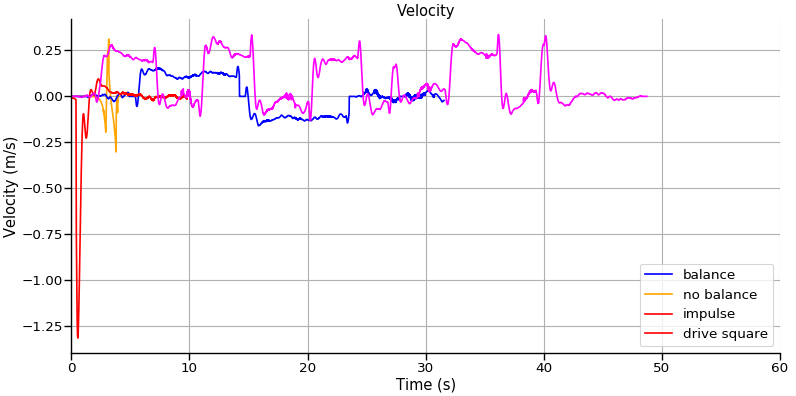

In [13]:
%matplotlib inline
cfg = pc['velocity'].copy()
cfg['runs'] = runs
cfg['colors'] = ['orange', 'blue', 'red', 'magenta']
cfg['linestyles'] = ['-', '-', '-', '-']
cfg['legend'] = {
    'no balance': {
        'color': 'orange',
        'linestyle': '-'
    },
    'balance': {
        'color': 'blue',
        'linestyle': '-'
    },
    'impulse': {
        'color': 'red',
        'linestyle': '-'
    },
    'drive square': {
        'color': 'red',
        'linestyle': '-'
    },
}
cfg['xlim'] = [0.0, 60.0]
make_static_plot(df, cfg, 'VelocityVsTime')

### Tilt Plot

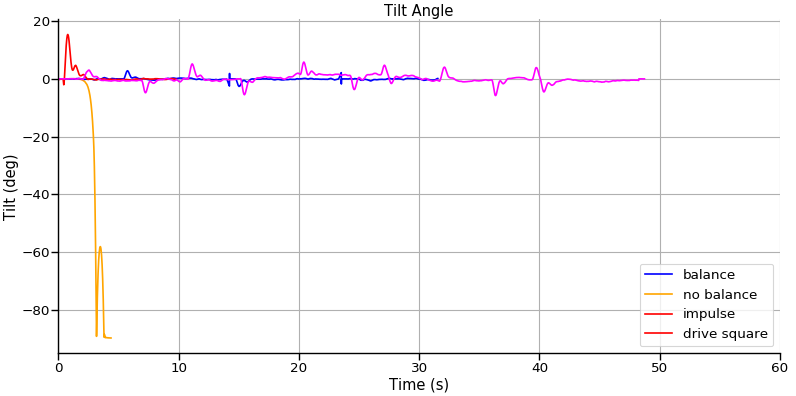

In [14]:
%matplotlib inline
cfg = pc['measured_tilt'].copy()
cfg['runs'] = runs
cfg['colors'] = ['orange', 'blue', 'red', 'magenta']
cfg['linestyles'] = ['-', '-', '-', '-']
cfg['legend'] = {
    'no balance': {
        'color': 'orange',
        'linestyle': '-'
    },
    'balance': {
        'color': 'blue',
        'linestyle': '-'
    },
    'impulse': {
        'color': 'red',
        'linestyle': '-'
    },
    'drive square': {
        'color': 'red',
        'linestyle': '-'
    },
}
cfg['xlim'] = [0.0, 60.0]
make_static_plot(df, cfg, 'TiltVsTime')

### Turn Rate Plot

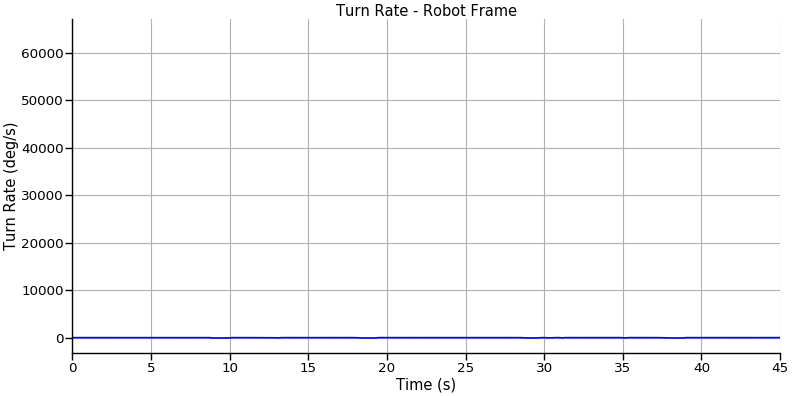

In [20]:
%matplotlib inline
cfg = pc['turn_rate'].copy()
cfg['runs'] = ['drive_square_js_response']
cfg['xlim'] = [0.0, 45.0]
make_static_plot(df, cfg, 'TurnRateVsTime')

### Heading Plot

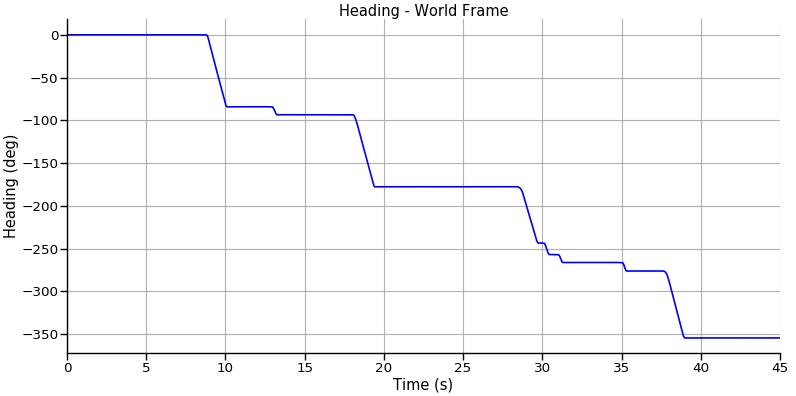

In [21]:
%matplotlib inline
cfg = pc['heading'].copy()
cfg['runs'] = ['drive_square_js_response']
cfg['xlim'] = [0.0, 45.0]
make_static_plot(df, cfg, 'DerivedHeadingVsTime')

### Position Plot

/home/mike/.local/lib/python2.7/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f867d30b690> has a label of u'_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/mike/.local/lib/python2.7/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f865ea8f7d0> has a label of u'_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


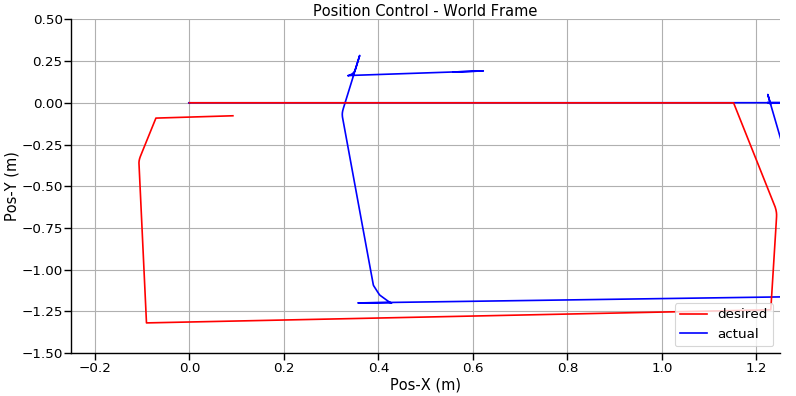

In [41]:
%matplotlib inline
cfg = pc['position_control'].copy()
cfg['runs'] = ['drive_square_js_response']
cfg['xlim'] = [-0.25, 1.25]
cfg['ylim'] = [-1.5, 0.5]
make_static_plot(df, cfg, 'PositionControl', plot_func=desired_vs_actual_for_runs)

/home/mike/.local/lib/python2.7/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f867d14ff50> has a label of u'_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/mike/.local/lib/python2.7/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f867d184d90> has a label of u'_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


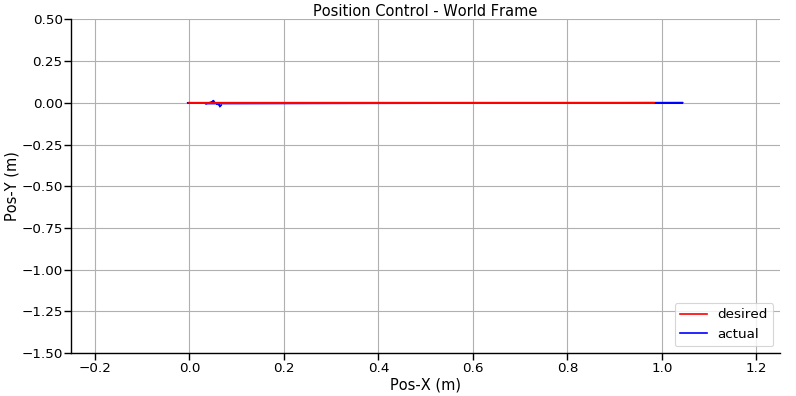

In [25]:
%matplotlib inline
cfg = pc['position_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [-0.25, 1.25]
cfg['ylim'] = [-1.5, 0.5]
make_static_plot(df, cfg, 'PositionControl', plot_func=desired_vs_actual_for_runs)

# Control Commands vs Response

### Desired Velocity vs Actual

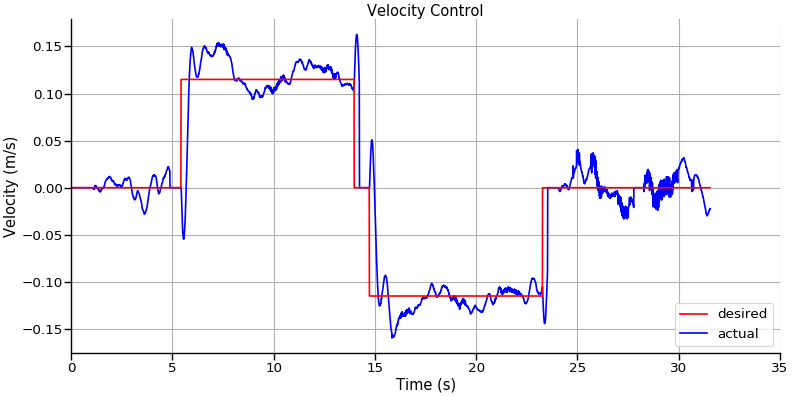

In [33]:
%matplotlib inline
cfg = pc['velocity_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'VelocityControl', plot_func=desired_vs_actual_for_runs)

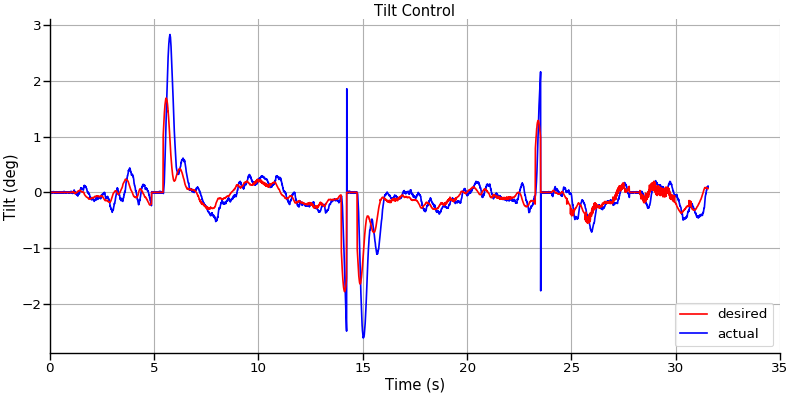

In [35]:
%matplotlib inline
cfg = pc['tilt_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'VelocityControl', plot_func=desired_vs_actual_for_runs)

### Desired Heading vs Actual

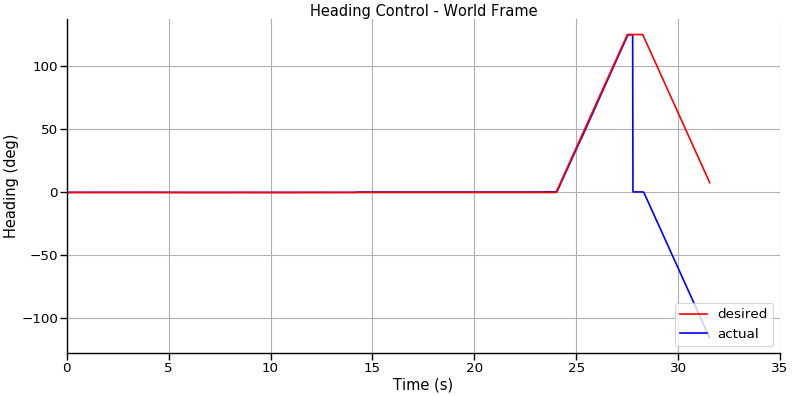

In [36]:
%matplotlib inline
cfg = pc['heading_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'HeadingControl', plot_func=desired_vs_actual_for_runs)

## Desired Turn Rate vs Actual

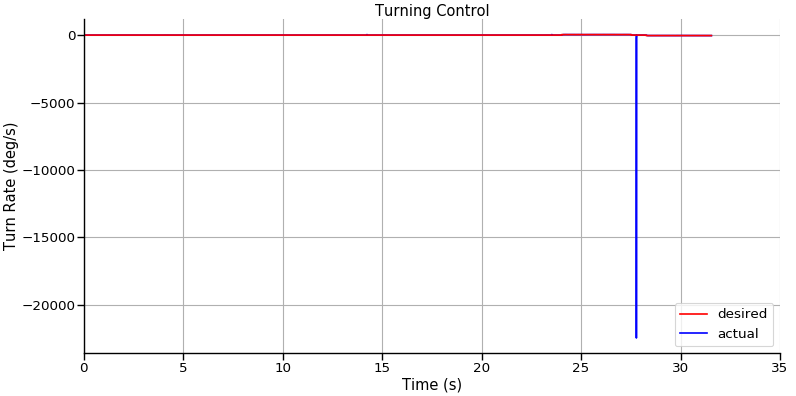

In [39]:
%matplotlib inline
cfg = pc['turning_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'TurningControl', plot_func=desired_vs_actual_for_runs)